# CNN

## Importing Libraries

In [1]:
from dotenv import load_dotenv
import os
import sys
load_dotenv()
# Mac Modified! add PYTHONPATH variable to .env file and set to root project directory
sys.path.insert(0, os.getenv("PYTHONPATH"))

In [2]:
import numpy as np

# Mac Modified! import tensorflow & keras independently
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, utils, datasets
from notebooks.utils import display

2023-09-10 00:18:41.069389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameters

In [3]:
NUM_CLASSES = 10

In [4]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train.astype("float32") / 255.0, x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

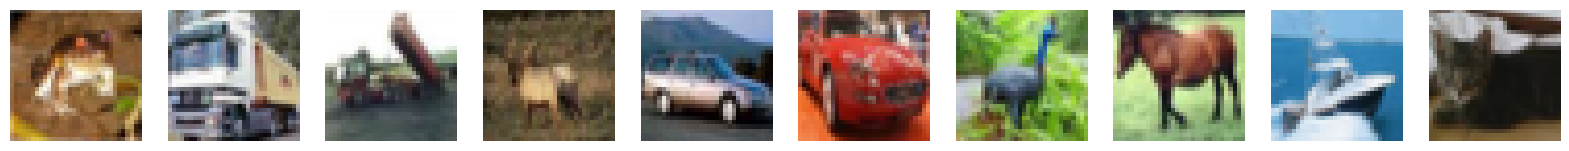

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [5]:
display(x_train[0:10])
print(y_train[0:10])

## Build the Model

In [6]:
input_layer = layers.Input(shape=(32,32,3))

x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=1, padding="same")(input_layer)
x = layers.BatchNormalization()(x) # fixes Exploding Gradient problem by reducing internal covariate shift 
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=(3,3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(units=128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)

x = layers.Dense(units=NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

model.summary()


2023-09-10 00:18:45.312188: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: AMD Radeon Pro 5300M
2023-09-10 00:18:45.312223: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-10 00:18:45.312231: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 1.99 GB
2023-09-10 00:18:45.312295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-10 00:18:45.312334: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                            

## Train the Model

In [7]:
adam_optimizer = optimizers.legacy.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy",
    optimizer=adam_optimizer,
    metrics=["accuracy"]
)

Facing Exploding Gradients problem,
So changing batch size from 32 to 64, to avoid hanging of python kernel & hence training.

In [8]:
with tf.device("/GPU"):
    model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=10,
        shuffle=True,
        validation_data=(x_test, y_test)
    )

Epoch 1/10


2023-09-10 00:18:47.546416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - ETA: 0s - loss: 1.5424 - accuracy: 0.4593

2023-09-10 00:19:32.145969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 49s 57ms/step - loss: 1.5424 - accuracy: 0.4593 - val_loss: 1.2751 - val_accuracy: 0.5483
Epoch 2/10
782/782 [==============================] - 42s 54ms/step - loss: 1.1464 - accuracy: 0.5955 - val_loss: 1.0583 - val_accuracy: 0.6207
Epoch 3/10
782/782 [==============================] - 42s 54ms/step - loss: 0.9828 - accuracy: 0.6534 - val_loss: 1.0085 - val_accuracy: 0.6531
Epoch 4/10
782/782 [==============================] - 43s 55ms/step - loss: 0.8829 - accuracy: 0.6918 - val_loss: 0.8817 - val_accuracy: 0.6900
Epoch 5/10
782/782 [==============================] - 46s 58ms/step - loss: 0.8199 - accuracy: 0.7132 - val_loss: 0.8719 - val_accuracy: 0.6977
Epoch 6/10
782/782 [==============================] - 45s 58ms/step - loss: 0.7695 - accuracy: 0.7316 - val_loss: 0.9122 - val_accuracy: 0.6864
Epoch 7/10
782/782 [==============================] - 45s 58ms/step - loss: 0.7217 - accuracy: 0.7468 - val_loss: 0.8910 - val_accuracy: 0.6945
Epo

## Evaluation

In [9]:
model.evaluate(x_test, y_test, batch_size=1000, verbose=1)

10/10 [==============================] - 1s 31ms/step - loss: 0.8342 - accuracy: 0.7164


[0.8342227339744568, 0.7164000272750854]

In [10]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

predictions = model.predict(x_test)
predictions_single = CLASSES[np.argmax(predictions, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

  1/313 [..............................] - ETA: 1:24

2023-09-10 00:58:23.179185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 3s 10ms/step


In [13]:
predictions_single

array(['cat', 'ship', 'ship', ..., 'dog', 'automobile', 'horse'],
      dtype='<U10')

Plotting the prediction and actual values

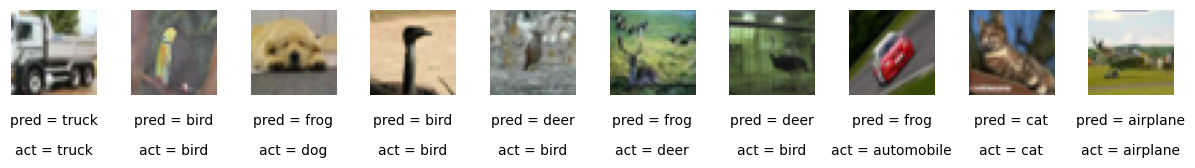

In [11]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(predictions_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)